In [21]:
# public libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

%load_ext tensorboard

2023-10-13 15:34:44.892543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 15:34:45.054974: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-13 15:34:45.718541: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-13 15:34:45.718644: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## retrieve data

In [3]:
# we'll read both of these values and the original input and irrelevant tcrs
X_cdr3s = pd.read_csv('../outputs/model_v3/cdr3.conversion.n30.csv', index_col=0)
X_epitopes = pd.read_csv('../outputs/model_v3/epitope.conversion.n15.csv', index_col=0)
hit = pd.read_csv('../outputs/model_v3/full.input.X.csv', index_col=0)
irr = pd.read_csv('../outputs/model_v3/full.control.X.csv', index_col=0)
irr = irr.reset_index().iloc[:, 1:]

In [4]:
# grab a subset
np.random.seed(0)
n_rows = 50000
perc_train = 0.75
# > subset target
idxs = np.random.choice(hit.index, size=n_rows, replace=False)
idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
print(len(idxs), len(idys))
hit_train, hit_test = hit.loc[idxs], hit.loc[idys]
# > subset control
idxs = np.random.choice(irr.index, size=n_rows, replace=False)
idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
print(len(idxs), len(idys))
irr_train, irr_test = irr.loc[idxs], irr.loc[idys]

37500 12500
37500 12500


In [5]:
# > subset target
val_idxs = hit.index[~hit.index.isin(hit_train.index.union(hit_test.index))]
print(len(val_idxs))
hit_val = hit.loc[val_idxs]
# > subset control
val_idxs = irr.index[~irr.index.isin(irr_train.index.union(irr_test.index))]
print(len(val_idxs))
irr_val = irr.loc[val_idxs]

77014
38001


## split into testing and validation

In [38]:
# create X for testing
X_test = pd.concat([hit_test, irr_test], axis=0).reset_index().iloc[:, 1:]
X_test_cdr3s = X_cdr3s.loc[X_test['CDR3']].reset_index().iloc[:, 1:]
X_test_epitopes = X_epitopes.loc[X_test['Epitope']].reset_index().iloc[:, 1:]
# combine
X_test_cdr3s.columns = 'cdr3:' + X_test_cdr3s.columns
X_test_epitopes.columns = 'ag:' + X_test_epitopes.columns
X_test = X_test_cdr3s.join(X_test_epitopes)

# grab y for testing
y_test = pd.concat([pd.Series(np.ones(hit_test.shape[0])), pd.Series(np.zeros(irr_test.shape[0]))]).astype(int)
y_test = y_test.reset_index().iloc[:, 1:][0]

In [40]:
# read in normalization factors
means = pd.read_csv('../outputs/model_v5/model_v5.means.csv', index_col=0).iloc[:, 0]
stds = pd.read_csv('../outputs/model_v5/model_v5.stds.csv', index_col=0).iloc[:, 0]
# subset for relevant columns
X_test = X_test[means.index]
# normalize
X_test -= means
X_test /= stds

In [41]:
# load in the model
model = keras.models.load_model('../outputs/model_v5/model_v5.keras')

# gather cdr3s and epitopes for future work
cdr3s = pd.concat([hit_test, irr_test], axis=0).reset_index().iloc[:, 1:]['CDR3']
epitopes = pd.concat([hit_test, irr_test], axis=0).reset_index().iloc[:, 1:]['Epitope']

In [47]:
# subset test dataset for this antigen
antigen = 'GILGFVFTL'
X_test = X_test.loc[(epitopes == antigen).values]

In [46]:
from anndata import AnnData
# create anndata object for dimension reduction
adata = AnnData(X_test)

# retrieve the appropriate columns
cols_cdr3 = X_test.columns[X_test.columns.str.startswith('cdr3')]
cols_ag = X_test.columns[X_test.columns.str.startswith('ag')]
# compute out embedding from the model (green layer)
out_cdr3 = model.layers[2](model.layers[0](X_test[cols_cdr3].astype(float).values))
out_ag = model.layers[3](model.layers[1](X_test[cols_ag].astype(float).values))
out_cdr3ag = model.layers[5](model.layers[4]([out_cdr3, out_ag]))
# add embedding to anndata object
adata.obsm['X_cdr3ag'] = out_cdr3ag.numpy()

# compute the typical dimension reductions
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_cdr3ag', n_pcs=adata.obsm['X_cdr3ag'].shape[1])
sc.tl.umap(adata)

# add in the observations
adata.obs['CDR3'] = cdr3s.loc[(epitopes == antigen).values]
adata.obs['Epitope'] = epitopes.loc[(epitopes == antigen).values]

# fix plotting beautifulness
sc.settings.set_figure_params(dpi=100)

/tmp/ipykernel_23289/3752060248.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(X_test)
/home/dchen/anaconda3/envs/base_py38/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


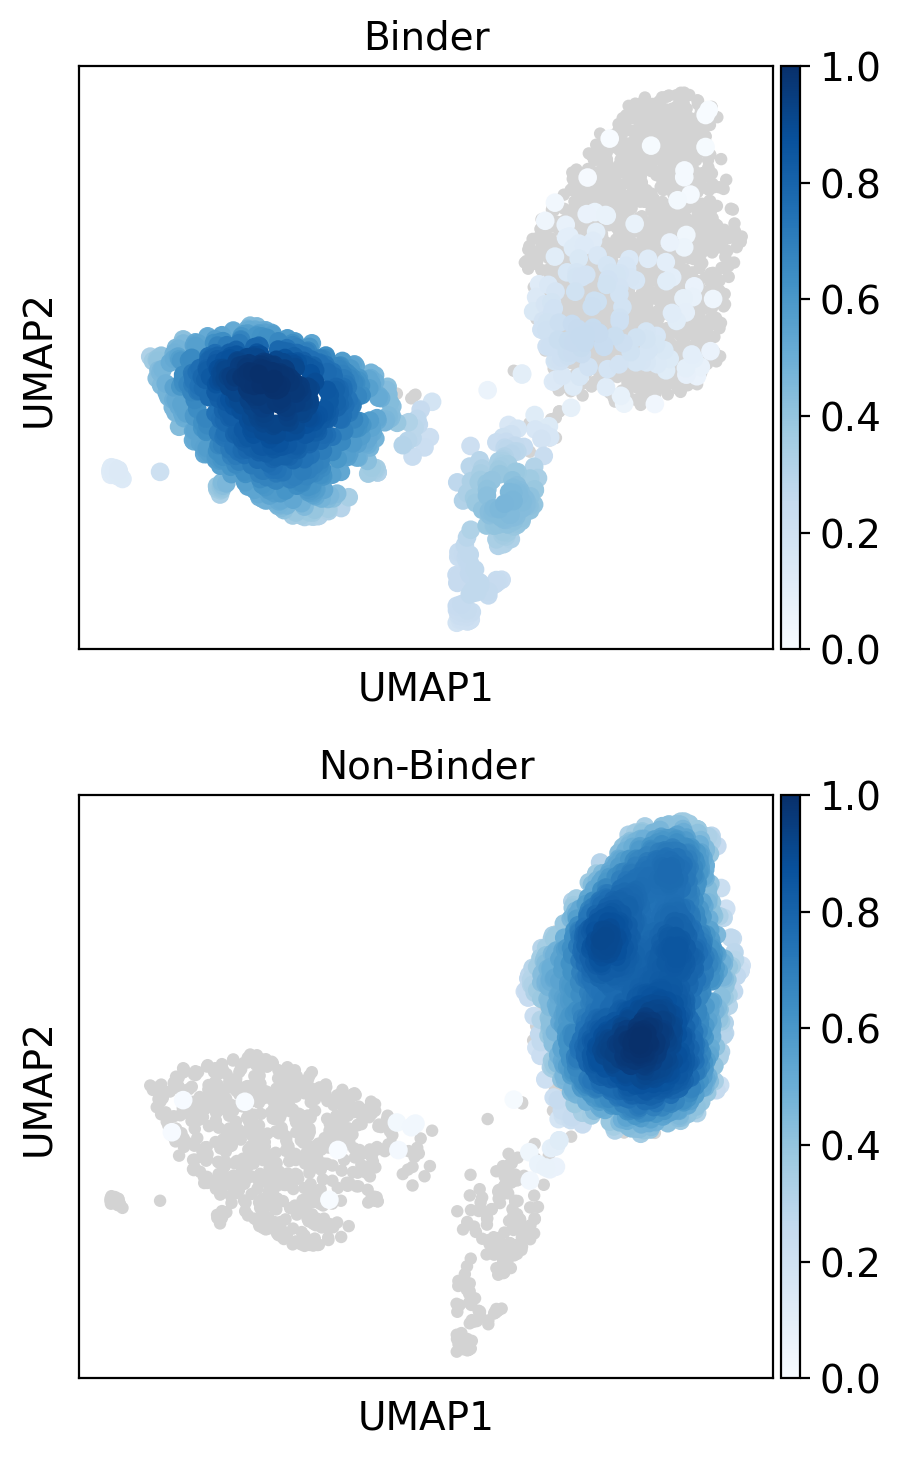

In [112]:
# plot the UMAP
adata.obs['Match'] = y_test[(epitopes == antigen).values].values
adata.obs['Match'] = pd.Categorical(adata.obs['Match'].map({0:'Non-Binder', 1:'Binder'}))
sc.tl.embedding_density(adata, groupby='Match')
sc.pl.embedding_density(adata, key='umap_density_Match', ncols=1, color_map='Blues')

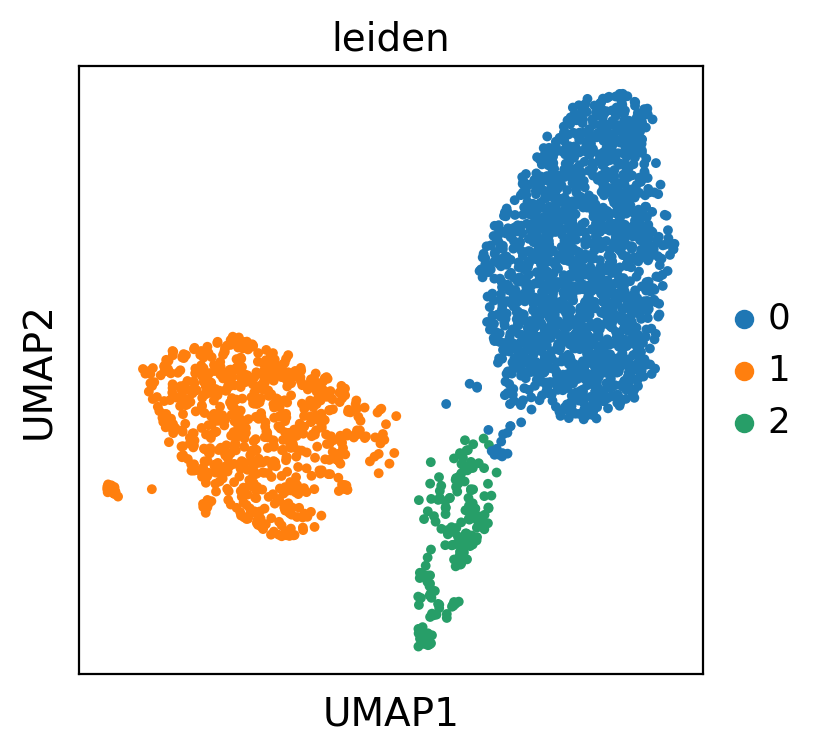

In [75]:
# compute leidens
sc.tl.leiden(adata, resolution=0.05)
sc.pl.umap(adata, color=['leiden'], s=50)

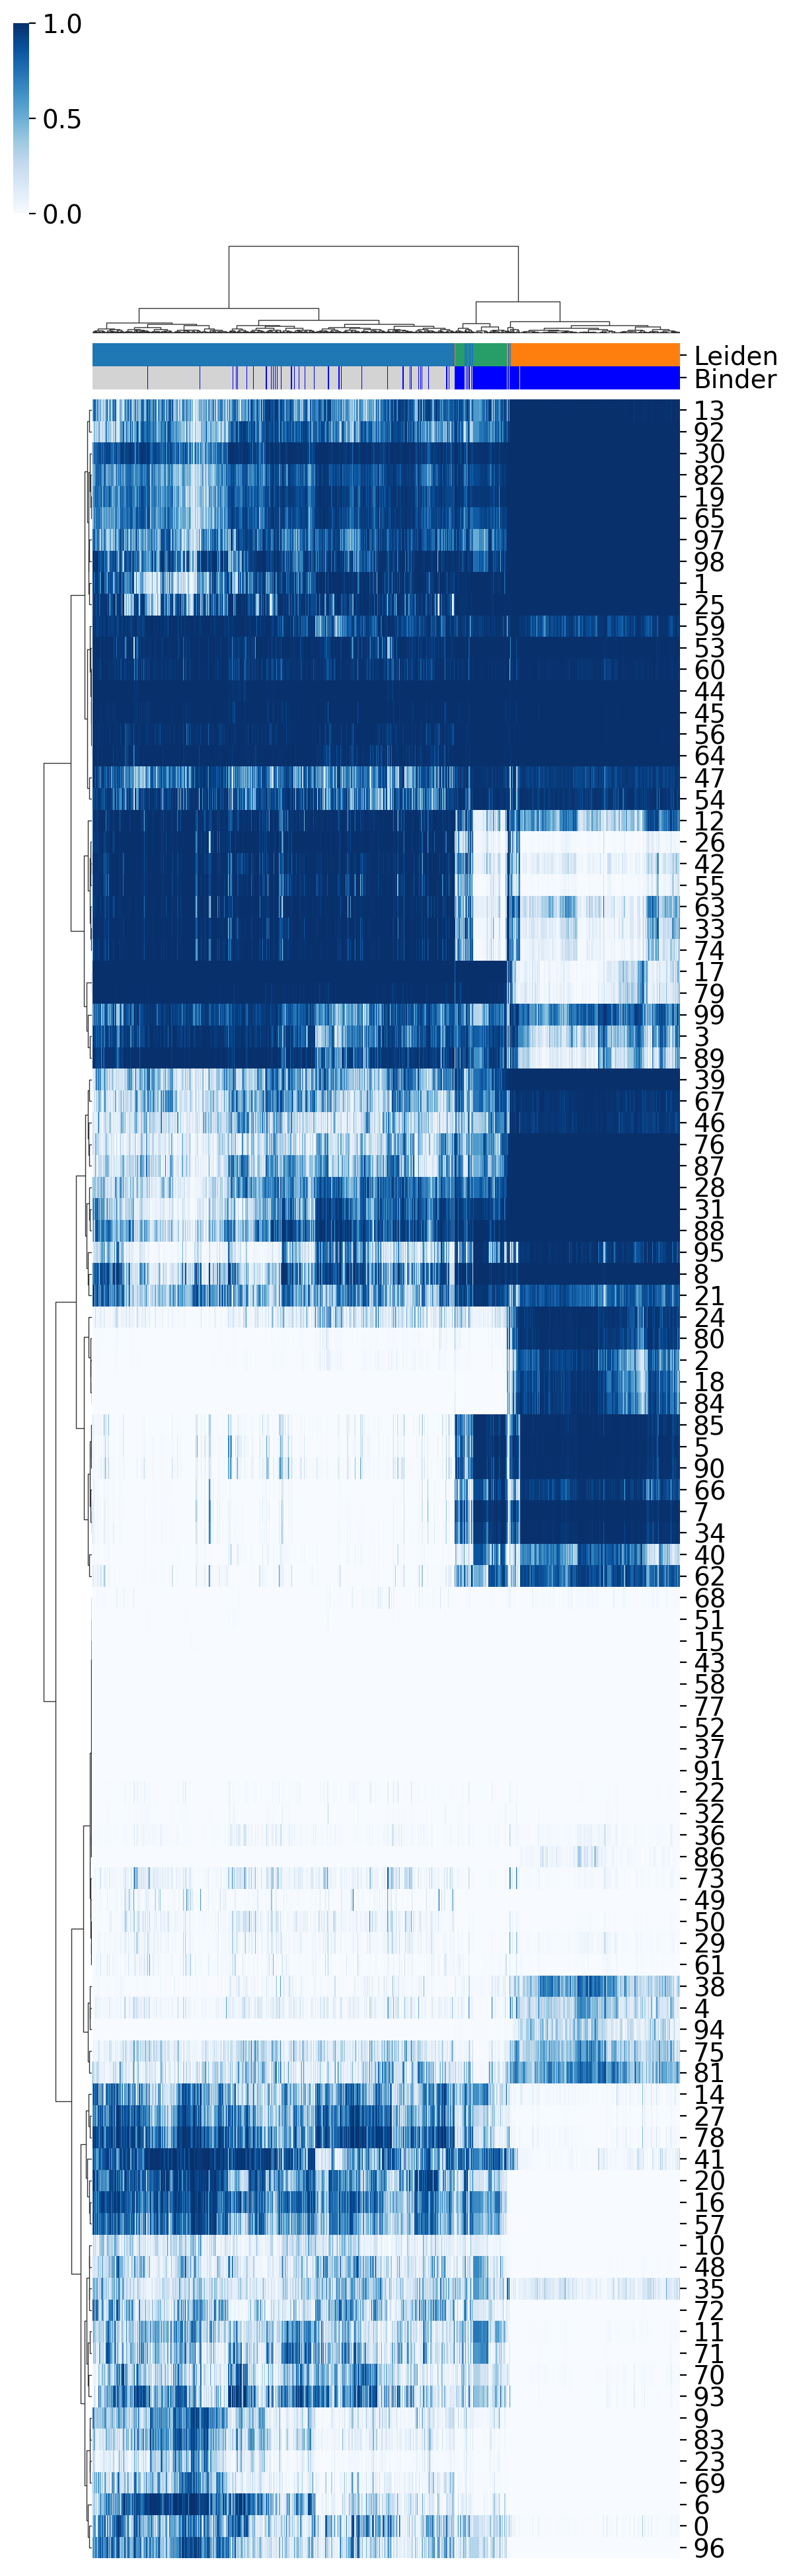

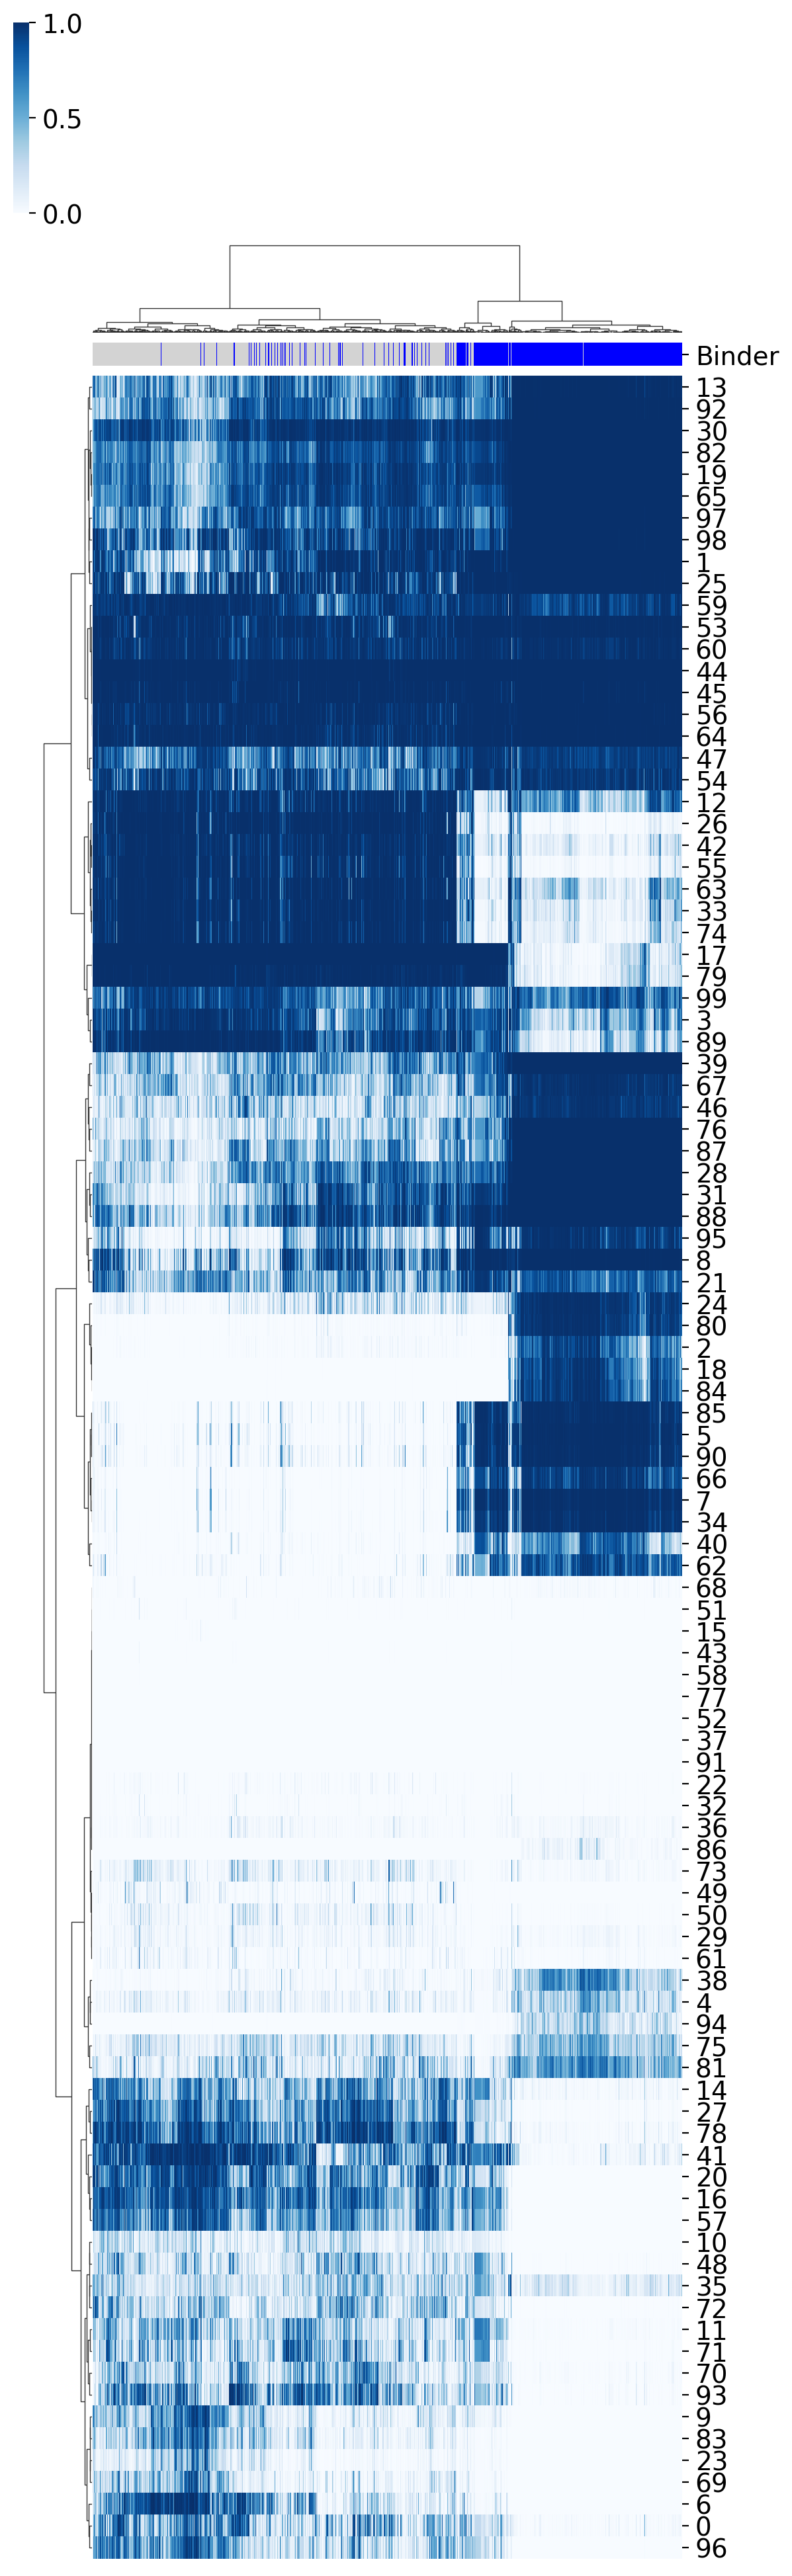

In [309]:
# determine which rulesets are most differential
plot = pd.DataFrame(adata.obsm['X_cdr3ag'])
pal_leiden = {adata.obs['leiden'].cat.categories.tolist()[idx]: col for idx, col in enumerate(adata.uns['leiden_colors'][:3])}
row_colors = adata.obs['leiden'].map(pal_leiden).reset_index().iloc[:, 1:]
pal_match = {adata.obs['Match'].cat.categories.tolist()[idx]: col for idx, col in enumerate(['b','lightgray'])}
row_colors = pd.concat([row_colors, adata.obs['Match'].map(pal_match).reset_index().iloc[:, 1:]], axis=1)
row_colors.columns = ['Leiden','Binder']

g = sns.clustermap(plot.T, col_colors=row_colors, method='ward', figsize=[6, 18],
                   xticklabels=0, yticklabels=1, colors_ratio=.01, dendrogram_ratio=(.08, .04),
                   cbar_pos=(0, 1, .02, .08), cmap='Blues')

g = sns.clustermap(plot.T, col_colors=row_colors[['Binder']], method='ward', figsize=[6, 18],
                   xticklabels=0, yticklabels=1, colors_ratio=.01, dendrogram_ratio=(.08, .04),
                   cbar_pos=(0, 1, .02, .08), cmap='Blues')

In [102]:
import scipy.stats as ss
# loop through each ruleset
order = [x.get_text() for x in g.ax_heatmap.get_yticklabels()]
mask_binder = row_colors['Binder'] == 'r'
pvalues = pd.Series()
for col in order:
    p = ss.mannwhitneyu(plot.loc[mask_binder, int(col)], plot.loc[~mask_binder, int(col)])[1]
    pvalues.loc[col] = p

(-1.0, 100.0)

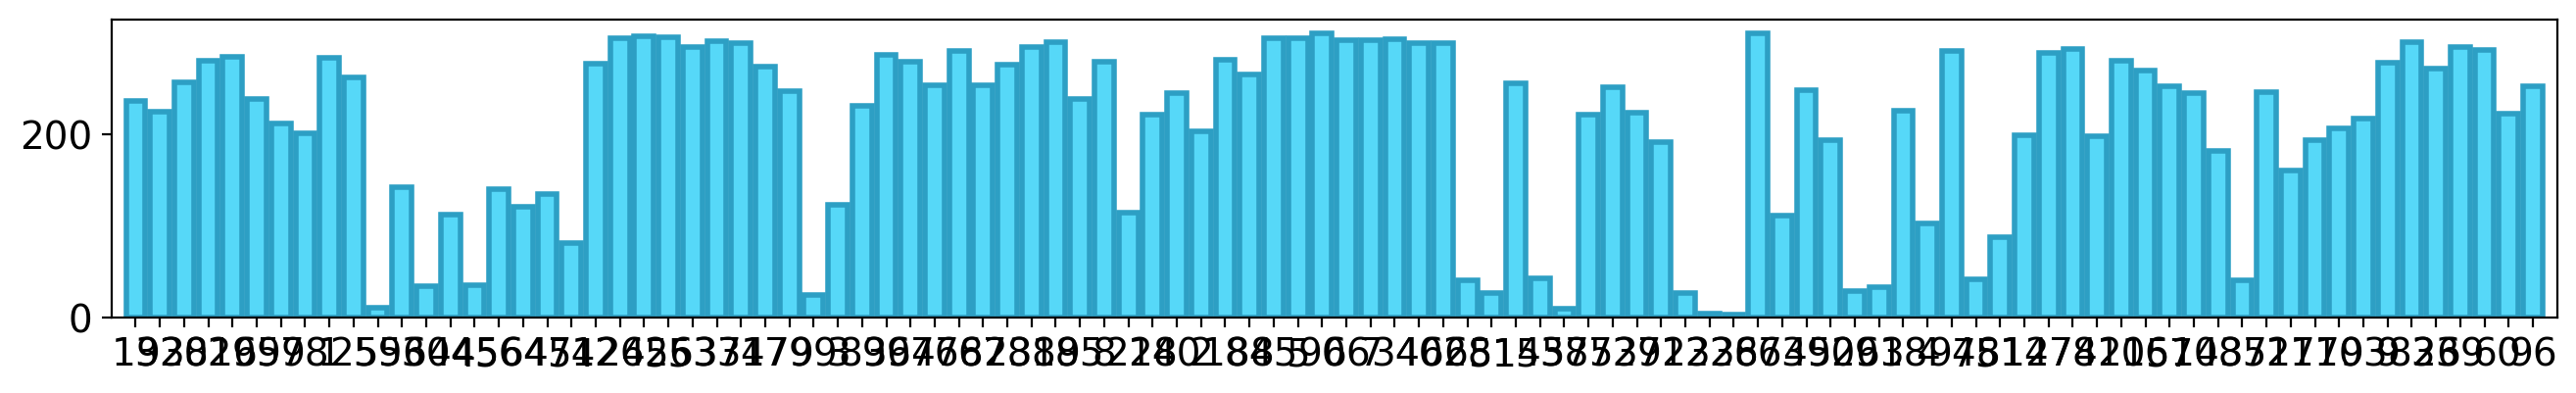

In [108]:
# plot pvalues
fig, ax = plt.subplots(figsize=[16, 2])
ax.grid(False)
ax.bar(pvalues.index, -np.log10(pvalues), color='#56D8F8', edgecolor='#2D9FC4', linewidth=2)
ax.set_xlim(-1, pvalues.shape[0])

In [302]:
def consider_value(value):
    # grab the cdr3 nodes for significantly weighted negative nodes
    cdr3_cols = weights.index[:10]
    cdr3_weights = pd.DataFrame(model.layers[2].kernel.numpy()[:, cdr3_cols], index=cols_cdr3)
    cdr3_weights.index = cdr3_weights.index.str.slice(5)
    cdr3_weights.columns = cdr3_cols
    cdr3_neg = (cdr3_weights.loc[cdr3_weights.index.str.endswith(value)] * abs(weights[:10])).mean(1)
    cdr3_neg.index = cdr3_neg.index.str.replace(value,'').astype(int)
    # grab the cdr3 nodes for significantly weighted positive nodes
    cdr3_cols = weights.index[-10:]
    cdr3_weights = pd.DataFrame(model.layers[2].kernel.numpy()[:, cdr3_cols], index=cols_cdr3)
    cdr3_weights.index = cdr3_weights.index.str.slice(5)
    cdr3_weights.columns = cdr3_cols
    cdr3_pos = (cdr3_weights.loc[cdr3_weights.index.str.endswith(value)] * abs(weights[-10:])).mean(1)
    cdr3_pos.index = cdr3_pos.index.str.replace(value,'').astype(int)

    # plot a few interesting metrics
    fig, ax = plt.subplots(figsize=[4, 4])
    ax.grid(False)
    ax.plot(cdr3_neg.index, cdr3_neg, color='b', linestyle='--')
    ax.plot(cdr3_pos.index, cdr3_pos, color='b')
    ax.set(xlabel='Position', ylabel=value.title())
    ax.plot([-1, 31], [0, 0], color='k')
    ax.set_xlim(-1, 31)
    
    # plot a few interesting metrics
    fig, ax = plt.subplots(figsize=[4, 4])
    ax.grid(False)
    ax.plot(cdr3_neg.index, cdr3_pos - cdr3_neg, color='b')
    ax.set(xlabel='Position', ylabel=value.title())
    ax.plot([-1, 31], [0, 0], color='k')
    ax.set_xlim(-1, 31)

/tmp/ipykernel_23289/2989032685.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xs, y=ys, errorbar=('ci', 95), err_kws={'linewidth': 2}, capsize=0.3,
/tmp/ipykernel_23289/2989032685.py:7: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(x=xs, y=ys, errorbar=('ci', 95), err_kws={'linewidth': 2}, capsize=0.3,


90 1.37844646220963e-310


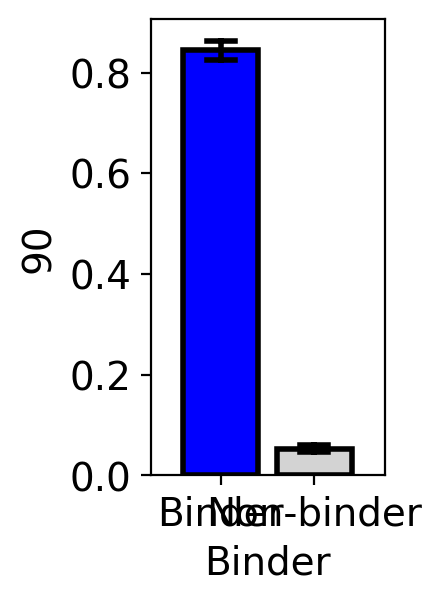

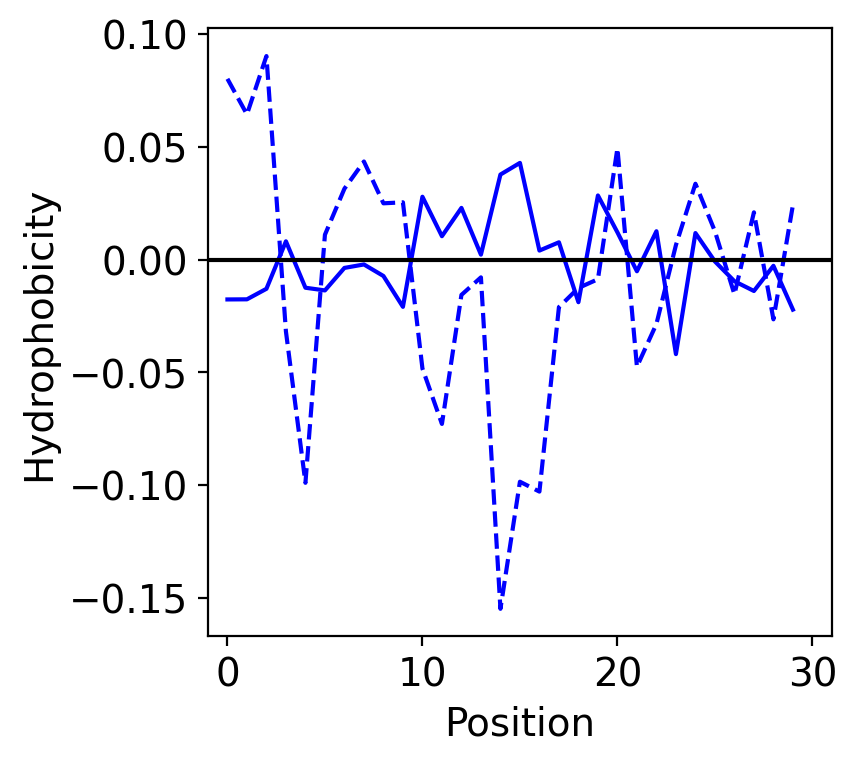

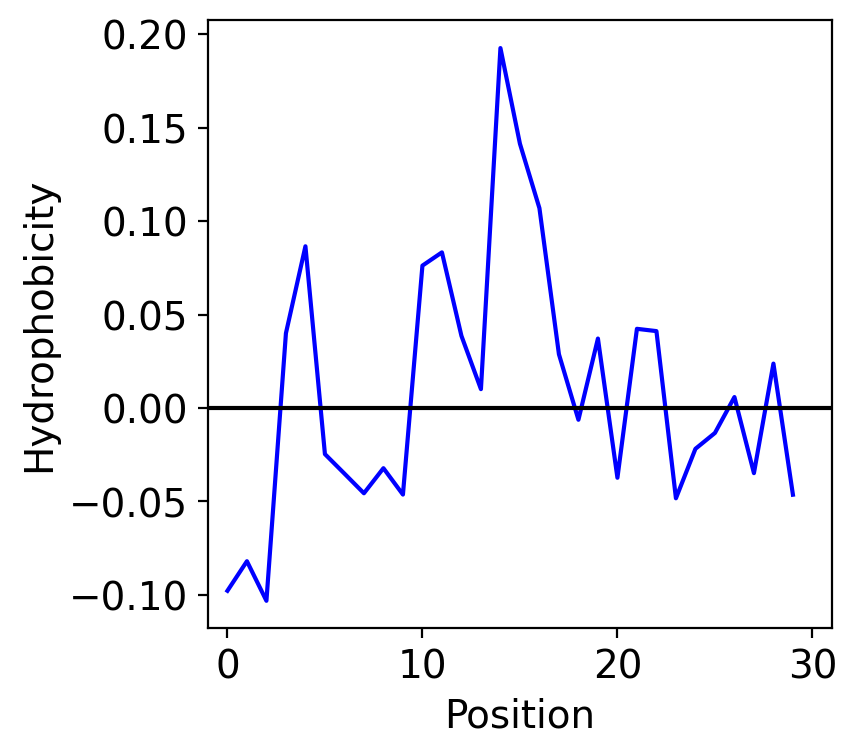

In [308]:
# for the most significant one check the pvalue and distribution
best = pvalues.sort_values().index[0]
xs = row_colors['Binder'].map({'b':'Binder', 'lightgray':'Non-binder'})
ys = plot[int(best)]
fig, ax = plt.subplots(figsize=[1.5, 3])
ax.grid(False)
sns.barplot(x=xs, y=ys, errorbar=('ci', 95), err_kws={'linewidth': 2}, capsize=0.3,
            saturation=1, palette=['b','lightgray'], edgecolor='k', errcolor='k', linewidth=2)
ax.set_xlim(-0.75, 1.75)
print(best, ss.mannwhitneyu(ys[xs == 'Binder'], ys[xs != 'Binder'])[1])

# weights that are most important for the given node
weights = pd.Series(model.layers[5].kernel.numpy()[:200, int(best)]).sort_values()

# plot the features
consider_value('hydrophobicity')

/tmp/ipykernel_23289/987834448.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xs, y=ys, errorbar=('ci', 95), err_kws={'linewidth': 2}, capsize=0.3,
/tmp/ipykernel_23289/987834448.py:7: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(x=xs, y=ys, errorbar=('ci', 95), err_kws={'linewidth': 2}, capsize=0.3,


42 3.1210454429577568e-307


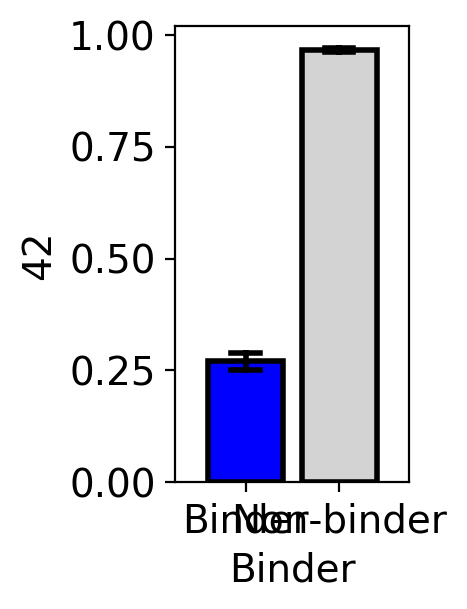

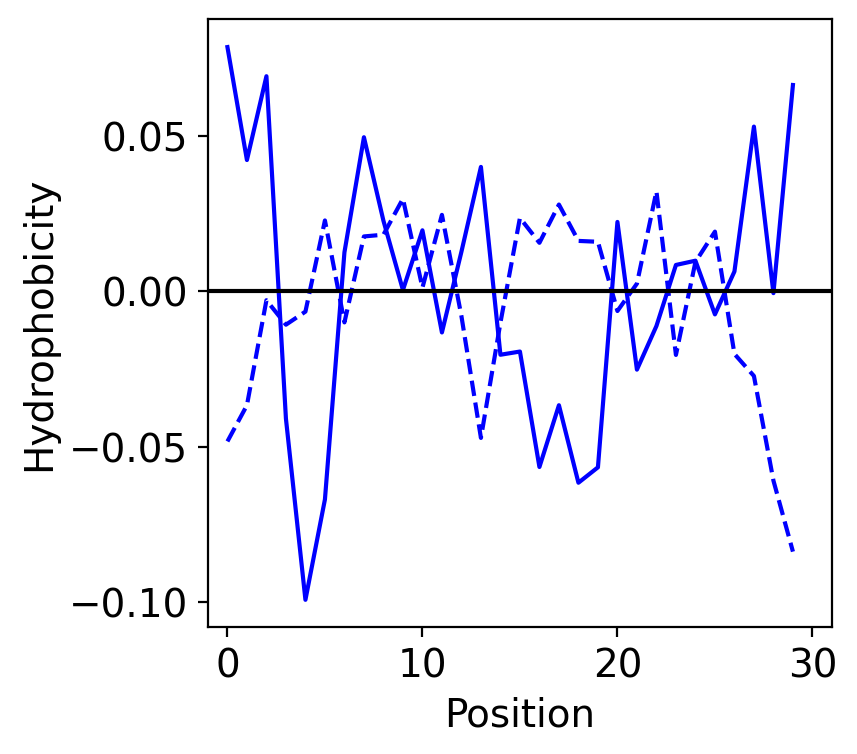

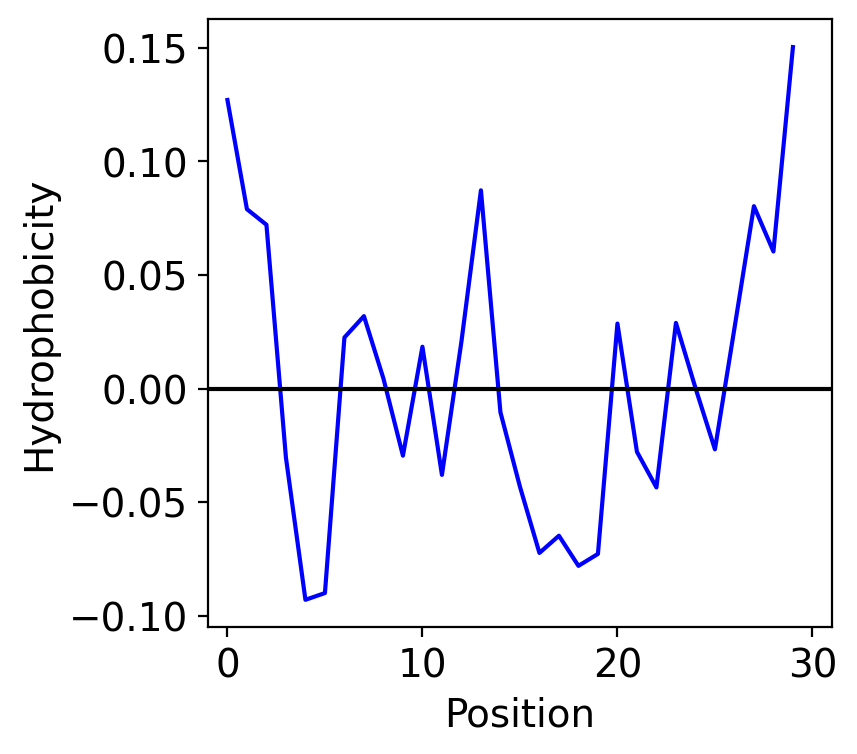

In [307]:
# for the most significant one check the pvalue and distribution
best = pvalues.sort_values().index[2]
xs = row_colors['Binder'].map({'b':'Binder', 'lightgray':'Non-binder'})
ys = plot[int(best)]
fig, ax = plt.subplots(figsize=[1.5, 3])
ax.grid(False)
sns.barplot(x=xs, y=ys, errorbar=('ci', 95), err_kws={'linewidth': 2}, capsize=0.3,
            saturation=1, palette=['b','lightgray'], edgecolor='k', errcolor='k', linewidth=2)
ax.set_xlim(-0.75, 1.75)
print(best, ss.mannwhitneyu(ys[xs == 'Binder'], ys[xs != 'Binder'])[1])

# weights that are most important for the given node
weights = pd.Series(model.layers[5].kernel.numpy()[:200, int(best)]).sort_values()

# plot the features
consider_value('hydrophobicity')